<a href="https://colab.research.google.com/github/Omar-Ouardighi/Fault-Diagnosis-using-Deep-Learning/blob/main/Fault_Diagnosis_using_Deep_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks (CNN) for bearings faults classification
In this Notebook, we will show results of fault diagnosis task using deep learning on the Case Western Reserve University bearing dataset.

## import libraries

In [1]:
import pandas as pd
import sklearn
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

##  Load Data


In [2]:
file = np.load('/content/drive/MyDrive/CWRU_48k_load_1_data.npz')
file.files

['data', 'labels']

In [3]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [4]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


We can see in the histogram below that data is well balanced 

<BarContainer object of 4600 artists>

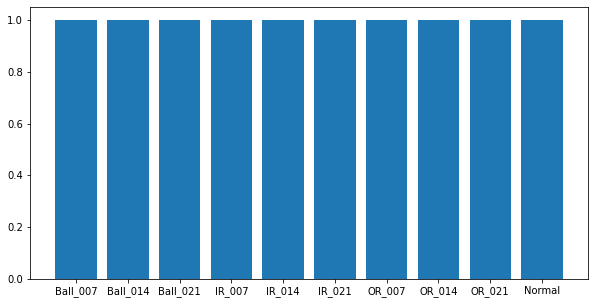

In [8]:

plt.figure(figsize=(10,5))
plt.bar(labels, height=1 )

In [9]:
labels = pd.Categorical(labels, categories = category_labels).codes
labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int8)

## Splitting the data

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 1000, random_state = 42, 
                                                                    stratify = labels)

In [11]:
# reshape data
train_data = train_data.reshape(len(train_data),32,32,1)
test_data = test_data.reshape(len(test_data),32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Shuffle data
index = np.random.permutation(len(train_labels))
trian_data, trian_labels = train_data[index], train_labels[index]

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(3600, 32, 32, 1) (3600, 10) (1000, 32, 32, 1) (1000, 10)


## Modeling
We will use the following model for classification.

In [12]:

model = Sequential([
    layers.Conv2D(32,5,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(64,3,activation = 'relu' ),
    layers.MaxPool2D(2),
    layers.Conv2D(128,3,activation = 'relu' ),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
    ])

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                  metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

history = model.fit(
      train_data, train_labels, 
      epochs=50,
      batch_size=16,
      validation_data=[test_data,test_labels],
      callbacks = [early_stopping] 
      )

Epoch 1/50
225/225 [==============================] - 12s 9ms/step - loss: 1.2030 - accuracy: 0.5381 - val_loss: 0.5290 - val_accuracy: 0.7850
Epoch 2/50
225/225 [==============================] - 2s 7ms/step - loss: 0.4549 - accuracy: 0.8083 - val_loss: 0.4217 - val_accuracy: 0.8190
Epoch 3/50
225/225 [==============================] - 2s 8ms/step - loss: 0.3799 - accuracy: 0.8356 - val_loss: 0.3635 - val_accuracy: 0.8460
Epoch 4/50
225/225 [==============================] - 2s 8ms/step - loss: 0.3477 - accuracy: 0.8561 - val_loss: 0.3218 - val_accuracy: 0.8570
Epoch 5/50
225/225 [==============================] - 2s 8ms/step - loss: 0.2970 - accuracy: 0.8706 - val_loss: 0.2632 - val_accuracy: 0.8800
Epoch 6/50
225/225 [==============================] - 2s 8ms/step - loss: 0.2249 - accuracy: 0.9003 - val_loss: 0.2947 - val_accuracy: 0.8850
Epoch 7/50
225/225 [==============================] - 2s 8ms/step - loss: 0.1812 - accuracy: 0.9219 - val_loss: 0.1820 - val_accuracy: 0.9340
Epoch

In [14]:
prediction = model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

true_labels = np.argmax(test_labels, axis = 1)


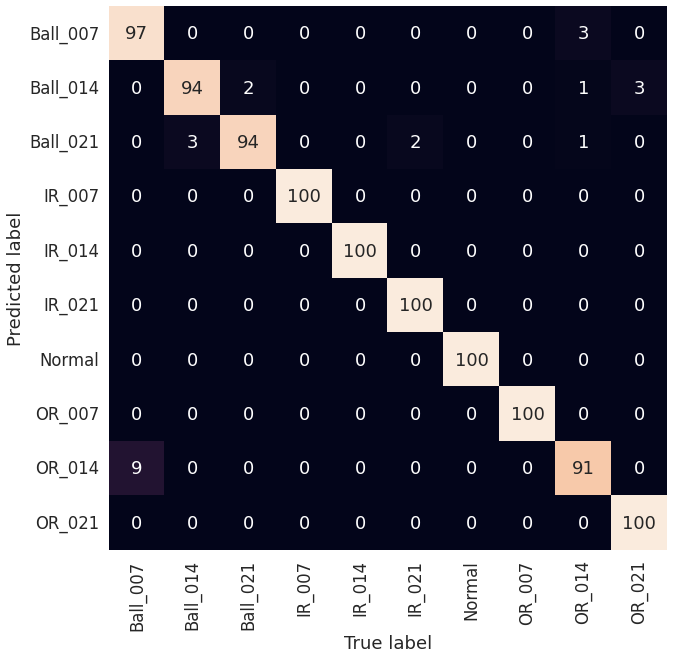

In [17]:
sns.set(font_scale=1.5 )

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     xticklabels = category_labels,
                     yticklabels = category_labels,
                     fmt = "d",
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
plot_conf_mat(true_labels, prediction_labels)

In [18]:
print(classification_report(true_labels, prediction_labels))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       100
           1       0.97      0.94      0.95       100
           2       0.98      0.94      0.96       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       0.98      1.00      0.99       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       0.95      0.91      0.93       100
           9       0.97      1.00      0.99       100

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

